(537, 691, 3)


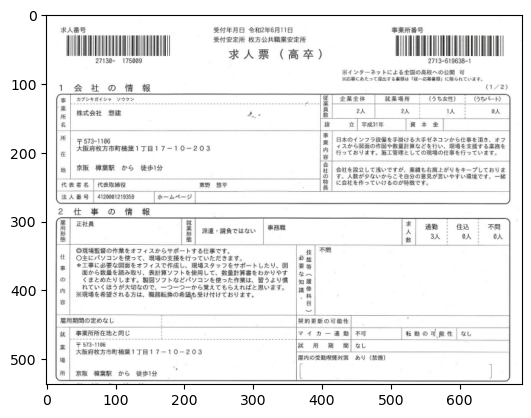

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

root_path = os.getcwd()
img_path = root_path+"/configs/image.png"
input_img = cv2.imread(img_path)
print(input_img.shape)
plt.imshow(input_img)

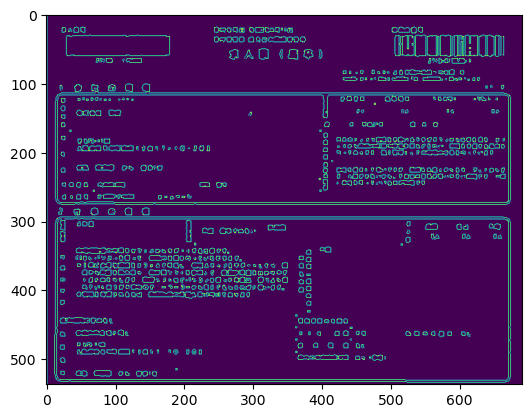

In [2]:

img = input_img.copy()

# Convert to Gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Make GaussianBlur (Normalized the colors)
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Perform Thresholding (Weak lines are disappeared)
thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]

# Perform Bilateral Filter
gray = cv2.bilateralFilter(thresh, 1, 100, 150)

# Perform Canny Edges Detections (Clear lines are become more clear)
imgThreshold = cv2.Canny(gray, 20, 250)



plt.imshow(imgThreshold)


In [3]:
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)

    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]

    return myPointsNew


##### What are contours?
Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

[[[ 14 299]]

 [[ 18 532]]

 [[673 529]]

 [[668 295]]]

[[[ 16 124]]

 [[ 20 273]]

 [[671 271]]

 [[666 117]]]



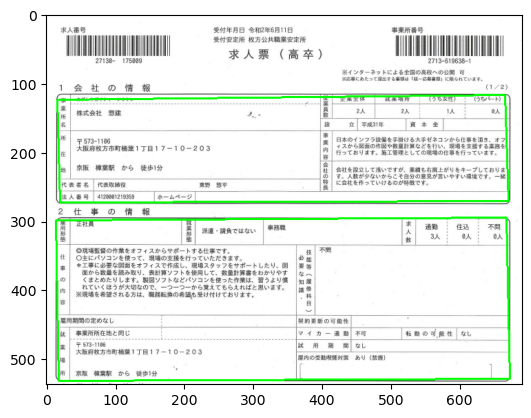

In [4]:

# FIND ALL CONTOURS
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rgb = img.copy()
rect_list = []

for i in contours:
    area = cv2.contourArea(i)

    if area > 8000:
        peri = cv2.arcLength(i, True)

        approx = cv2.approxPolyDP(i, 0.02 * peri, True)
        if len(approx) == 4:

            cv2.drawContours(rgb, [approx], -1, (0, 255, 0), 2)
            print(approx[:4])
            print()
            rect_list.append(reorder(approx[:4]))
plt.imshow(rgb)

True

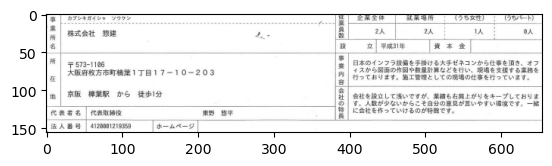

In [5]:
crop_img = img.copy()

i = 1

rect_result = rect_list

xindexs = [rect_result[i][0][0][0], rect_result[i][1][0][0], rect_result[i][2][0][0],
                rect_result[i][3][0][0]]

yindexs = [rect_result[i][0][0][1], rect_result[i][1][0][1], rect_result[i][2][0][1],
                rect_result[i][3][0][1]]


y1 = np.min(yindexs)
y2 = np.max(yindexs)
x1 = np.min(xindexs)
x2 = np.max(xindexs)


cropped_img = crop_img[y1:y2,x1:x2,:]
plt.imshow(cropped_img)


#Save image
cv2.imwrite("configs/block_1.png",cropped_img)

1. Create GCP account and Enable Vertex AI API and Cloud Vision API
2. Create service account with only Enable Vertex AI API user.
3. Download and add to cred

In [6]:
#!pip install python-dotenv
#!pip install google-cloud-vision

In [7]:
from dotenv import load_dotenv
print(load_dotenv())
print(os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))


True
/Users/tharhtet/Documents/github/ML-in-Prod-batch-1/3_image_processing_techniques/OCR_proj/credentials/service_account.json


In [9]:


import io
from  google.cloud  import  vision
client = vision.ImageAnnotatorClient()
with io.open(img_path, 'rb') as image_file:
    content = image_file.read()

image = vision.Image(content=content)


I0000 00:00:1721365146.662313   54891 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


In [10]:
response = client.text_detection(image=image)
response

text_annotations {
  locale: "ja"
  description: "\346\261\202\344\272\272\347\225\252\345\217\267\n27130- 175009\n1 \344\274\232\347\244\276\343\201\256\346\203\205\345\240\261\n\344\272\213 \343\202\253\343\203\226\343\202\267\343\202\255\343\202\254\343\202\244\343\202\267\343\203\243 \343\202\275\343\202\246\343\202\261\343\203\263\n\345\217\227\344\273\230\345\271\264\346\234\210\346\227\245 \344\273\244\345\222\2142\345\271\2646\346\234\21011\346\227\245\n\345\217\227\344\273\230\345\256\211\345\256\232\346\211\200 \346\236\232\346\226\271\345\205\254\345\205\261\350\201\267\346\245\255\345\256\211\345\256\232\346\211\200\n\346\261\202\344\272\272\347\245\250 (\351\253\230\345\215\222)\n\346\240\252\345\274\217\344\274\232\347\244\276 \345\273\272\n\346\211\200\n\345\220\215\n\346\211\200\n573-1106\n\345\244\247\351\230\252\345\272\234\346\236\232\346\226\271\345\270\202\347\224\272\346\245\240\350\221\2111\344\270\201\347\233\25617-10-203\n\345\234\250\n\344\272\254\351\230\252\

In [12]:
import json
def load_template_frame(jsonTemplate_path):


    block_shapes = None
    template_infos = []

    with open(jsonTemplate_path, 'r') as json_file:
        data = json.load(json_file)
        block_shapes = data['shapes']

    for cur_bk in (block_shapes):
        label = cur_bk['label']
        points = cur_bk['points']
        x, y, x2, y2 = int(points[0][0]), int(points[0][1]), int(points[1][0]), int(points[1][1])

        template_infos.append([label, x, y, x2, y2])
    return template_infos



jsonTemplate_path = os.getcwd()+"/templates/block_1.json"
template_infos = load_template_frame(jsonTemplate_path)
print(template_infos)

[['1b_01', 1, 0, 47, 110], ['1b_02', 47, 0, 874, 31], ['1b_03', 48, 30, 872, 110], ['1b_04', 874, 2, 912, 76], ['1b_05', 910, 1, 1053, 31], ['1b_06', 911, 30, 1054, 75], ['1b_07', 1055, 1, 1201, 31], ['1b_08', 1054, 32, 1201, 75], ['1b_09', 1203, 1, 1349, 32], ['1b_10', 1203, 32, 1348, 77], ['1b_11', 1349, 0, 1498, 31], ['1b_12', 1498, 77, 1349, 30], ['1b_13', 874, 75, 995, 114], ['1b_14', 998, 75, 1158, 111], ['1b_15', 1158, 75, 1279, 112], ['1b_16', 1280, 76, 1498, 114], ['1b_17', 0, 109, 46, 259], ['1b_18', 47, 110, 873, 262], ['1b_19', 912, 207, 874, 113], ['1b_20', 914, 113, 1498, 208], ['1b_21', 873, 208, 911, 299], ['1b_22', 912, 207, 1498, 301], ['1b_23', 1, 259, 122, 297], ['1b_24', 124, 261, 872, 300], ['1b_25', 1, 297, 123, 334], ['1b_26', 123, 297, 323, 335], ['1b_27', 324, 299, 459, 335], ['1b_28', 460, 299, 1499, 335]]


In [13]:
def load_xmlResponsesText(response):
        responseText_infos = []
        document = response.full_text_annotation
        for page in document.pages:
            for block in page.blocks:
                for paragraph in block.paragraphs:
                    for word in paragraph.words:
                        for symbol in word.symbols:
                            bbox = symbol.bounding_box
                            xmin = bbox.vertices[0].x
                            ymin = bbox.vertices[0].y
                            xmax = bbox.vertices[2].x
                            ymax = bbox.vertices[2].y
                            xcenter = (xmin + xmax) / 2
                            ycenter = (ymin + ymax) / 2

                            text = symbol.text
                            responseText_infos.append([text, xcenter, ycenter])
        return responseText_infos

In [14]:
responseText_infos = load_xmlResponsesText(response)
responseText_infos

[['求', 25.5, 23.5],
 ['人', 34.5, 23.5],
 ['番', 43.5, 23.5],
 ['号', 53.5, 23.5],
 ['2', 73.5, 67.5],
 ['7', 77.5, 67.5],
 ['1', 83.0, 67.5],
 ['3', 87.5, 67.5],
 ['0', 92.5, 67.5],
 ['-', 98.0, 67.5],
 ['1', 111.0, 67.5],
 ['7', 116.5, 67.5],
 ['5', 121.5, 67.5],
 ['0', 126.5, 67.5],
 ['0', 130.5, 67.5],
 ['9', 136.0, 67.5],
 ['1', 25.0, 107.5],
 ['会', 46.5, 107.5],
 ['社', 71.0, 107.5],
 ['の', 96.0, 107.5],
 ['情', 120.0, 107.5],
 ['報', 144.5, 107.5],
 ['事', 24.0, 125.0],
 ['カ', 46.5, 123.5],
 ['ブ', 53.5, 123.5],
 ['シ', 60.0, 123.5],
 ['キ', 65.5, 123.5],
 ['ガ', 73.0, 123.5],
 ['イ', 78.5, 123.5],
 ['シ', 85.5, 123.5],
 ['ャ', 91.5, 123.5],
 ['ソ', 104.5, 123.5],
 ['ウ', 111.5, 123.5],
 ['ケ', 119.0, 123.5],
 ['ン', 125.0, 123.5],
 ['受', 246.5, 23.5],
 ['付', 256.5, 23.5],
 ['年', 266.0, 23.5],
 ['月', 274.5, 23.5],
 ['日', 284.5, 23.5],
 ['令', 298.0, 23.5],
 ['和', 307.5, 23.5],
 ['2', 314.0, 23.5],
 ['年', 321.5, 23.5],
 ['6', 327.0, 23.5],
 ['月', 334.5, 23.5],
 ['1', 341.5, 23.5],
 ['1', 347.5, 23.

In [15]:
def match_Template(template_infos,responseText_infos):
    result_dict = {}
    for bbox in template_infos:
        label, xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3], bbox[4]
        texts = ''
        for text_info in responseText_infos:
            text = text_info[0]
            xcenter = text_info[1]
            ycenter = text_info[2]
            if xmin <= xcenter <= xmax and ymin <= ycenter <= ymax:
                texts += text
            result_dict[label] = str(texts)

    
    return  result_dict
result_dict = match_Template(template_infos,responseText_infos)
(result_dict)



{'1b_01': '求人番1会',
 '1b_02': '号受付年月日令和2年6月11日事業所番号',
 '1b_03': '27130-175009社の情報受付安定所枚方公共職業安定所求人票(高卒)2713-619638-1※インターネットによる全国の高校への公開可※応募にあたって提出する書類は一応書に限られています。(1/2)',
 '1b_04': '',
 '1b_05': '',
 '1b_06': '',
 '1b_07': '',
 '1b_08': '',
 '1b_09': '',
 '1b_10': '',
 '1b_11': '',
 '1b_12': '',
 '1b_13': '',
 '1b_14': '',
 '1b_15': '',
 '1b_16': '',
 '1b_17': '事所名所在地代表者',
 '1b_18': 'ブシキガイシャソウケン株式会社建573-1106大阪府枚方市町楠葉1丁目17-10-203京阪樟葉駅から徒歩1分名代表取締役東野-想平從業員数企菜全体就菜場所(うち女性)(うちパート)2人2人人0人設立平成31年資本金事業内容会社の特長日本のインフラ設備を手掛ける大手ゼネコンから仕事を頂き、オフィスから図面の作図や数量計算などを行い、現場を支援する業務を行っております。施工管理としての現場の仕事を行っています。会社を設立して浅いですが、業績も右肩上がりをキープしております。人数が少ないからこそ自分の意見が言いやすい環境です。一緒に会社を作っていけるのが特徴です。',
 '1b_19': '',
 '1b_20': '',
 '1b_21': '',
 '1b_22': '',
 '1b_23': '法人番号41200012193522仕事の情',
 '1b_24': '9ホームページ報',
 '1b_25': '雇用形態正社員',
 '1b_26': '就業形派遣・請負ではない',
 '1b_27': '事務職',
 '1b_28': '求人拉通勤3人住込0人不問0人'}